### Zillow Regression Project

#### Project Goals:

- Construct a machine learning regression model that improves predicted propery tax assessed values of single family homes.
- Find the key drivers of property value for single family properties.
- Forcast tax assessed home value with enhanced accuracy.
- Empower zillow executives to improve the current predictions using my recommentations.
- Thoroughly document the process and key findings.

#### Summary of Findings & Recommendations:
- My analysis indicates that the top drivers of tax assessed home values are:
     > - property size (square footage)
     > - property's year built
     > - location (zip code)
     > - bedroom count
     > - bathroom count

- I built and trained an ordinary least squares (OLS) linear regression model which is able to improve predict tax assessed home values by ~ $80,000.
 
- By utilizing this model with the top drivers of tax assessed home values , I can recommend employing this new model with reasonable confidence.

#### Data Acquistion & Preparation
- Import necessary libraries
- Import user defined functions (acquire.py, wrangle.py)
- Data imported meets the following conditions:
    > - single family homes in Orange county, CA, Ventura, CA, or Los Angeles, CA
    > - had a transaction in 2017
    > - data available in zillow properties_2017 table

In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import wrangle
import prepare

from tabulate import tabulate
from IPython.display import Markdown, display

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from math import sqrt
from scipy import stats

In [2]:
df = acquire.get_zillow_data()
# this is a user-defined function in acquire.py that pulls in selected data from the SQL database

In [3]:
df.info()
# gives an overview of the imported data including number of records, column names, number of non-null records, and datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    52441 non-null  int64  
 1   parcelid                      52441 non-null  int64  
 2   taxvaluedollarcnt             52440 non-null  float64
 3   bedroomcnt                    52441 non-null  float64
 4   bathroomcnt                   52441 non-null  float64
 5   yearbuilt                     52325 non-null  float64
 6   fips                          52441 non-null  float64
 7   calculatedfinishedsquarefeet  52359 non-null  float64
 8   lotsizesquarefeet             52072 non-null  float64
 9   latitude                      52441 non-null  float64
 10  longitude                     52441 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.4 MB


#### Acquired data includes:

   > - parcelid: property identifier
    > - bedroomcnt: bedroom count of property
    > - bathroomcnt: bathroom count of property
    > - yearbuilt: property's year built
    > - fips: county of property
    > - calculatedfinishedsquarefeet: square footage of property
    > - lotsizesquarefeet: square footage of property's lot/land
    > - latitude: latitude coordinate of property
    > - longitude: longitude coordinate of property


#### Handling Null (missing) Values:

In [4]:
df.isna().sum() 
# shows the number of null values in each column in the dataframe

Unnamed: 0                        0
parcelid                          0
taxvaluedollarcnt                 1
bedroomcnt                        0
bathroomcnt                       0
yearbuilt                       116
fips                              0
calculatedfinishedsquarefeet     82
lotsizesquarefeet               369
latitude                          0
longitude                         0
dtype: int64

In [5]:
def printmd(string): # function to format text style
    display(Markdown(string))
printmd('***Number of records with nulls in all 3 columns:*** {:,} records'
     .format(df['calculatedfinishedsquarefeet'].isna().sum()  & df['yearbuilt'].isna().sum() & df['calculatedfinishedsquarefeet'].isna().sum()))
# shows how many records with nulls have null values in all 3 columns where nulls are present
printmd('***Percentage of nulls in the entire dataframe:*** {:,.2%} of records'
     .format(df.isna().sum().sum() / len(df)))
# shows how many records with nulls have null values in all 3 columns where nulls are present

***Number of records with nulls in all 3 columns:*** 80 records

***Percentage of nulls in the entire dataframe:*** 1.08% of records

##### Decision to drop null values:

Because the dataframe only has 1% of records with null values, dropping these records in the data preparation stage will not impact data integrity.

In [6]:
df = wrangle.wrangle_zillow(df)
# this pre-defined user function cleans and prepares as well as reducing the number of outliers in features.

In [7]:
df = df[df.year_built > 1910]

#### Univariate Exploration

- Explore and visualize the data independently 
- The goal of this step is to get to know the data well

In [8]:
zillow_summary = prepare.zillow_summary(df)
# this pre-defined user function calculates the minimum, maximum, and average value of selected features.

**Zillow Data (Min, Max, Average)**

--------------------------------


**Tax Assessed Value of Home**

*Maximum Tax Assessed Value: 8,946,027*

*Minimum Tax Assessed Value: 40,017*

*Average Tax Assessed Value: 518,460*

--------------------------------


**Home Size in Square Feet**

*Maximum Home Size: 12,616 square feet*

*Minimum Home Size: 501 square feet*

*Average Home Size: 1,921 square feet*

--------------------------------


**Lot Size in Square Feet**

*Maximum Lot Size: 6,971,010 square feet*

*Minimum Lot Size: 540 square feet*

*Average Lot Size: 11,246 square feet*

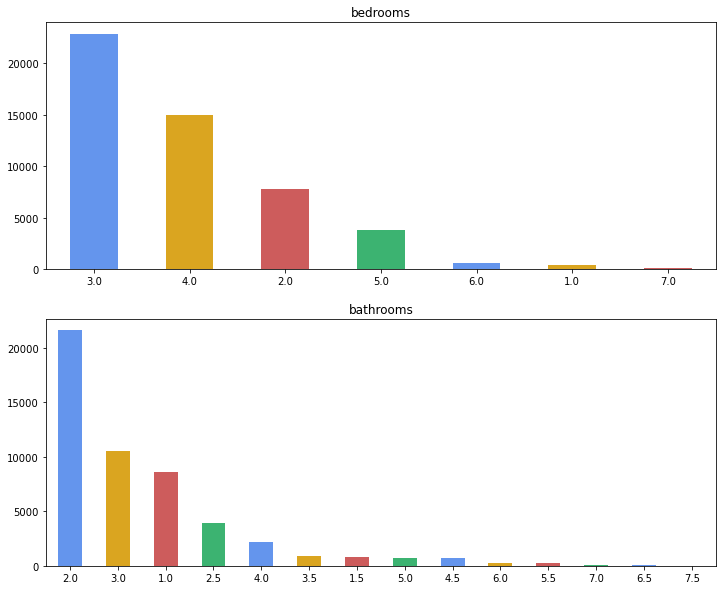

In [9]:
bedbath_counts = ['bedrooms','bathrooms']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (12, 10))

for i, item in enumerate(bedbath_counts):
        ax = df[item].value_counts().plot(kind = 'bar', color = ["cornflowerblue", "goldenrod", "indianred", "mediumseagreen"], ax=axes[i],rot = 0)
    
        ax.set_title(item)
        
# Displays a graphical representation of number of properties with x number of bedrooms and bathrooms

#### Bedroom & Bathroom Counts summary:

Properties having 3 bedrooms and 2 bathrooms is most common, whereas having more than 5 bedrooms and/or bathrooms is least common.

Text(0.5, 1.0, 'Year Built Distribution')

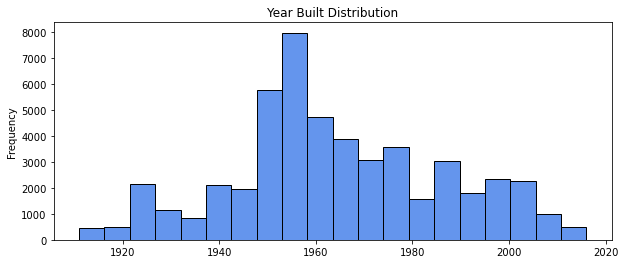

In [10]:
plt.figure(figsize=(10, 4))
df.year_built.plot.hist(by= df, bins=20, color = "cornflowerblue", ec= "black")
plt.title('Year Built Distribution')

#### Year Built Distribution summary:

- Properties built in the 1950s, 1960s, and 1970 are most frequent. 
- A very small percentage of homes were built before 1900.

#### Exploratory Data Analysis & Statistical Testing

- Create hypotheses regarding drivers of tax assessed property values.
- Split data into 3 subsets for proper statistical analysis and modeling.
- Create hypotheses relating to customer churn.
- Visualize bivariate and/or multivariate data and assess hypotheses using statistical tests.

#### Hypotheses & Exploration Plan:

> #1.)  Location - Based on basic domain knowledge, I believe location plays a large role in determining tax assessed property value. While the county may be a driver of the target(tax assessed property value), I'd like to dive deeper by narrowing in on location even further. Location determines other unknown attributes (such as proximity to the ocean, school district, etc.) which could greatly impact tax assessed value. Zip codes in the original data are incorrect and do not align with properties in California. Therefore, I will use latitude and longitude coordinates to explore the notion that location may drive the target variable.

> #2.) Square Footage - I hypothesize that home size and potentially lot size are related to tax assessed property value. Logically, I would anticipate larger home having a higher tax assessed value. I'm not sure whether or not the lot size will good predictor of the target as smaller homes may be on a lot of land and vice versa, yet it's possible that lot size and the target are correlated the majority of the time. I will explore these notions through graphical and statistical anaylsis.

> #3.) Rooms Counts - I believe that as the number of bedrooms and bathroom increases, the tax assessed property value increases. However, there is not much variance in these features and an overwhelming majority of properties have the same number of bedrooms and/or bathrooms. Because of this, I hypothesize that bedroom and bathroom counts will not be the top drivers of the target. Because my basic domain knowledge tells me that room counts likely impact value, I will explore these potential relationships.

> #4.) Year Built - My intuition tells me that more modern homes may have enhanced attributes which could mean that year built may be positively correlated to the target. However, my research shows that "historic homes" only need to be 50 years old (or more) and historic homes may be valued higher. I am unsure if (and how many) homes in this dataset are classified as "historic" and whether or not such homes would be considered outliers. I hypothesis that the majority of home ages are coorelated with the target as such older homes would have lower tax assessed values. I will explore this notion and keep an eye out for outliers.

#### Splitting Data

Splitting data into 3 subsets (train, validate, test) for proper statistical anaylsis, exploration, modeling, and assessment. 
- Train: explore features and relationships to target variable, statisitcal analysis, build models 
- Validate: evaluate model performace compared to the train dataset, Assess potential overfitting
- Test: run only the chosen top performing to ensure model performs as expected on unseen data before employing

In [11]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Train Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Train Records:** {:,}'
     .format(len(test)))

# Splits data into 3 subsets: train, validate, test. 

**Number of Train Records:** 28,323

**Number of Train Records:** 12,139

**Number of Train Records:** 10,116

<AxesSubplot:title={'center':'Feature Correlation (contiuous variables) of to Tax Assessed Value'}>

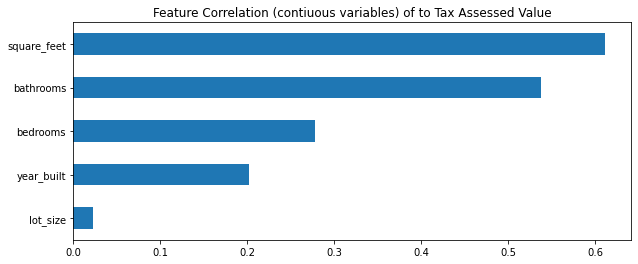

In [12]:
plt.figure(figsize=(10, 4))
plt.title("Feature Correlation (contiuous variables) of to Tax Assessed Value")
corr_chart = train.drop(['tax_value', 'fips', 'Unnamed: 0', 'parcelid', 'longitude', 'latitude'], axis=1).corrwith(train['tax_value']).sort_values().plot.barh()
corr_chart

# graphs the correlation strength of features to the target variable

#### Feature Correlation graph summary:
   - The home size appears to be a strong driver of the target whereas the lot size appears to have essentially no correlation. Therefore, I will move forward with evaluating the relationship of home square footage to tax assessed value. 
   - Bathroom count seems to be more valuable in predicting the tax assessed value than bedroom count. 
   - The year built correlation does not look as strong as the others, but may potentially be useful

#### Square Footage and Tax Assessed Value Exploration

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by County) to Tax Assessed Value')

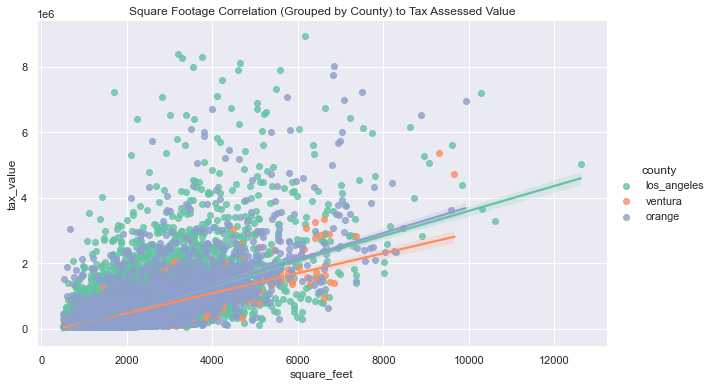

In [29]:
sns.set_palette('Set2', 20)
sns.lmplot(x='square_feet', y='tax_value', data=train, scatter=True, hue='county', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by County) to Tax Assessed Value")

# plots the correlation of the two variables on a scatter plot with a linear regression line, hue is added to show this relationship by each county

#### Square Footage Coorelation (Grouped by County) Graph Summary: 

Interestingly, square footage for properties in Venura County seems to be strongly correlated  with tax assessed value. The other two counties show a weaker correlation so I will run a statistical analysis on each county separately to assess this correlation.

#### Statisical Assessment

- Pearson r test to determine the potential correlation of square footage and tax assessed value by county

#### Setting Alpha 

- Alpha is set to an industry standard of .05 which will be the threshold in determine statistical significance  

$H_0$: There is no linear correlation between between square footage of ventura homes and tax assessed value

$H_a$ : There is a linear correlation between between square footage of ventura homes and tax assessed value

In [14]:
alpha = .05

ventura = pd.DataFrame(train[train.county=='ventura'])

xv = ventura.square_feet
yv = ventura.tax_value

corrv, pv = stats.pearsonr(xv, yv)

if pv > alpha:
    print("We fail to reject the null hypothesis")
elif corrv < .5:
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

#pearsonr test that returns correlation strength (r value) and p value (must be less than alpha to reject the null hypothesis)

We reject the null hypothesis


$H_0$: There is no linear correlation between between square footage of los angeles homes and tax assessed value

$H_a$ : There is a linear correlation between between square footage of los angeles homes and tax assessed value

In [15]:
la = pd.DataFrame(train[train.county=='los_angeles'])

xl = la.square_feet
yl = la.tax_value

corrl, pl = stats.pearsonr(xl, yl)

if pl > alpha:
    print("We fail to reject the null hypothesis")
elif corrl < .5:
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

#pearsonr test that returns correlation strength (r value) and p value (must be less than alpha to reject the null hypothesis)

We reject the null hypothesis


$H_0$: There is no linear correlation between between square footage of orange co homes and tax assessed value

$H_a$ : There is a linear correlation between between square footage of orange co homes and tax assessed value

In [16]:
orange = pd.DataFrame(train[train.county=='orange'])

xo = orange.square_feet
yo = orange.tax_value

corro, po = stats.pearsonr(xo, yo)

if po > alpha:
    print("We fail to reject the null hypothesis")
elif corro < .5:
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

#pearsonr test that returns correlation strength (r value) and p value (must be less than alpha to reject the null hypothesis)

We reject the null hypothesis


$H_0$: There is no linear correlation between between square footage of homes in all 3 counties and tax assessed value

$H_a$ : There is a linear correlation between between square footage of homes in all 3 counties and tax assessed value

In [17]:
x = train.square_feet
y = train.tax_value

corr, p = stats.pearsonr(x, y)

if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .5:
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

We reject the null hypothesis


In [18]:
printmd('**Correlation between Ventura Home Size and Tax Assessed Value:** ')
print(f' r = {corrv:.3f}') 
print()
printmd('**Correlation between LA Home Size and Tax Assessed Value:**')
print(f' r = {corrl:.3f}')
print()
printmd('**Correlation between Orange Co Home Size and Tax Assessed Value:** ')
print(f' r = {corro:.3f}')
print()
printmd('**Correlation between All 3 County Home Size and Tax Assessed Value:** ')
print(f' r = {corr:.3f}')

# prints out the r values of the pearsonr tests which shows the strength of the correlation 

**Correlation between Ventura Home Size and Tax Assessed Value:** 

 r = 0.766



**Correlation between LA Home Size and Tax Assessed Value:**

 r = 0.573



**Correlation between Orange Co Home Size and Tax Assessed Value:** 

 r = 0.669



**Correlation between All 3 County Home Size and Tax Assessed Value:** 

 r = 0.611


#### Takeaways from Pearsons r tests on square footage by county: 

The correlation strength of the home size and tax assessed value is definitely different based on county. Since home size is the strongest feature correlationThis is important as it make be beneficial to build separate models for each county to maximize this valuable correlation where possible. 

#### Bedrooms, Bathrooms and Tax Assessed Value Exploration

Text(0.5, 1.0, 'Number of Bathrooms and Tax Assessed Value')

<Figure size 1008x360 with 0 Axes>

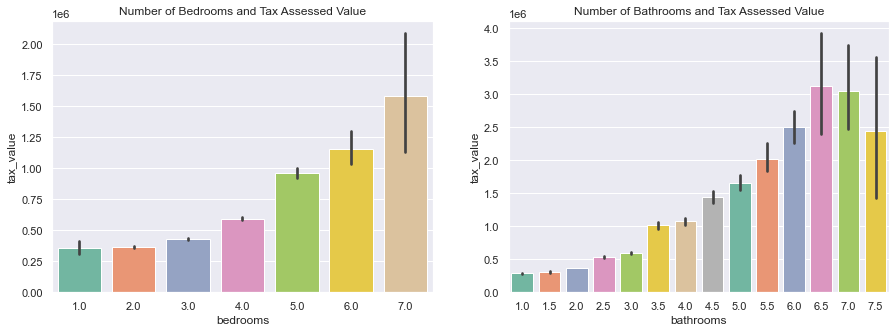

In [19]:
plt.figure(figsize=(14, 5))
sns.set_palette('Set2', 20)
#sets size and color palette for the grapgh

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
#creates subplots that share a y axis

sns.barplot(ax=axes[0], x=train.bedrooms, y=train.tax_value)
axes[0].set_title('Number of Bedrooms and Tax Assessed Value')
#creates first subplot

sns.barplot(ax=axes[1], x=train.bathrooms, y=train.tax_value)
axes[1].set_title('Number of Bathrooms and Tax Assessed Value')
#creates second subplot

#### Takeaways from Visualizations of Room Counts and Target Relationships: 

- Both bedroom count and bathroom count show a linear relationship with tax assessed value.
- However, the majority of homes fall between having 2-4 bedrooms and 1-3 bathrooms
- The linear relationship of room counts with the majorty of homes is much weaker than that of home's having greater than 4 bedrooms and/or bathrooms.
- These relationships may still be valuable for modeling, but will not be the strongest predictors.

Text(0.5, 1.0, 'Year Built Correlation (Grouped by County) to Tax Assessed Value')

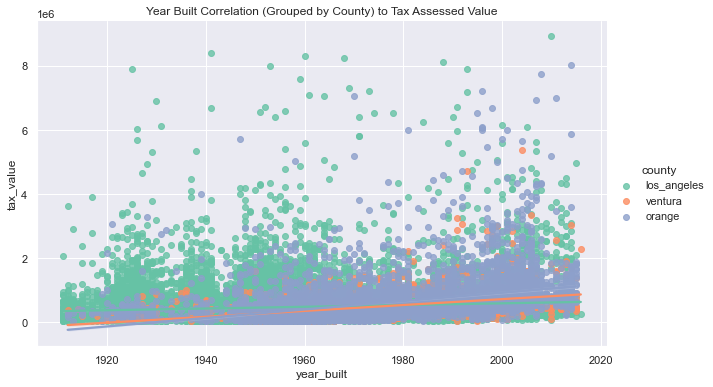

In [27]:
sns.lmplot(x='year_built', y='tax_value', data=train, scatter=True, hue='county', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Year Built Correlation (Grouped by County) to Tax Assessed Value")

# plots the correlation of the two variables on a scatter plot with a linear regression line, hue is added to show this relationship by each county

#### Year Built Correlation (Grouped by County) Graph Summary: 

Similarly to other features, year built for properties in Venura County have a stronger correlation tax assessed value than the other counties. Year built for properties in Orange county appear to have some linear correlation whereas year built for properies in LA county have a very weak correlation. This further emphasizes the rationale for building models based on counties seperately.

#### Pre-Modeling

In [32]:
train_ventura = pd.DataFrame(train[train.county=='los_angeles'])
train_orange = pd.DataFrame(train[train.county=='los_angeles'])
train_la = pd.DataFrame(train[train.county=='los_angeles'])



,Unnamed: 0,parcelid,tax_value,bedrooms,bathrooms,year_built,fips,square_feet,lot_size,latitude,longitude,county
21340,21340,11185483,326341,7.0,3.0,2000,6037,3130,11254,34613491.0,-118207291.0,los_angeles
41578,41578,11085699,640723,4.0,4.0,1961,6037,2249,11051,34251660.0,-118610278.0,los_angeles
46904,46904,17247487,408011,3.0,2.5,2012,6111,1371,4425,34263064.0,-118736584.0,ventura
26116,26116,14436618,720785,5.0,3.0,2001,6059,3289,6683,33476425.0,-117612680.0,orange
50526,50526,10961539,1275000,3.0,4.0,1938,6037,2855,9906,34151486.0,-118347548.0,los_angeles
...,...,...,...,...,...,...,...,...,...,...,...,...
12408,12408,11950507,42406,4.0,1.0,1923,6037,1236,4797,34112668.0,-118251033.0,los_angeles
32587,32587,11061719,407403,4.0,2.0,1960,6037,1783,7785,34231474.0,-118490419.0,los_angeles
20864,20864,11962808,409839,3.0,2.0,1964,6037,1460,4969,34110508.0,-118224300.0,los_angeles
16986,16986,12926547,363458,3.0,1.0,1953,6037,952,6167,34091310.0,-117927089.0,los_angeles


In [31]:
X_train = train[train.drop(columns=['Unnamed: 0', 'parcelid', 'tax_value', 'fips'])]
X_validate =
X_test =

NameError: name 'X' is not defined